# Cleaning up the World-Food-Facts Dataset

_Victor Ramirez_

1.1-1.6 are taken straight from Fabien Daniel's kaggle notebook. <br/>
1.7 was my attempt to further clean up this dataset in order to suit our purposes. Namely, we wanted to extract the macronutrients, their calorie counts, and feed them to Alexa


# **Food Feed Facts**
_Fabien Daniel (September 2017)_
___
In this notebook, I explore the content of the Open Food Facts dataset. The main points addressed concern the cleaning of the dataset but subsequently, I also try to get some insights on the quality of food types.
___
**Acknowledgement** many thanks to [J. Abécassis](https://www.kaggle.com/judithabk6) for the advices and help provided during the writing of this notebook 
___
1. Cleaning
     - 1.1 Empty rows and columns
     - 1.2 Redundant variables
     - 1.3 Countries
     - 1.4 Keywords
         * 1.4.1  The **categories_en** column
         * 1.4.2 The **pnns_groups_1** and  **pnns_groups_2** variables
     - 1.5 Filling factor
     - 1.6 Dispersion of the products content
2. Correlations 
3. Evaluating the quality of products 
     - 3.1 Nutrition grade
     - 3.2 Nutriments

___
## 1. Cleaning

First, I load all the packages that will be used in the notebook:

In [1]:
import pandas as pd
from math import pi
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS
from scipy.stats.stats import pearsonr
import seaborn as sns
import numpy as np
import matplotlib as mpl
#plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None # Warning for chained copies disabled

and then load the dataset:

In [2]:
df = pd.read_csv('en.openfoodfacts.org.products.tsv', low_memory=False, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 445.5+ MB


___
### 1.1 Empty rows and columns

At this stage, the dataframe contains $\sim$333'000 products which are described according to 165 variables. Looking at these variables, we can see that some of them do not contain any product:

In [3]:
def filling_factor(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = (df.shape[0]-missing_df['missing_count'])/df.shape[0]*100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)
    return missing_df
#____________________________________
missing_df = filling_factor(df)
missing_df[missing_df['filling_factor'] == 0]

,column_name,missing_count,filling_factor
0,water-hardness_100g,356027,0
1,ingredients_from_palm_oil,356027,0
2,ingredients_that_may_be_from_palm_oil,356027,0
3,nutrition_grade_uk,356027,0
4,-nervonic-acid_100g,356027,0
5,-erucic-acid_100g,356027,0
6,-mead-acid_100g,356027,0
7,-elaidic-acid_100g,356027,0
8,-butyric-acid_100g,356027,0
9,-caproic-acid_100g,356027,0


Hence I drop them:

In [4]:
df = df.dropna(axis = 1, how = 'all')
df.shape

(356027, 147)

In the following, I will mainly focus on products that contain some information on its nutriments. This information is contained in the variables with the **\_100g** suffix. Hence, I will only keep the products where at least one of these columns contain some information:

In [5]:
#_______________________
# looking at empty raws
composant = []
for s in df.columns:
    if '_100g' in s: composant.append(s)
df_subset_columns = df[composant]
print('empty _100g raws: {}'.format(df_subset_columns.isnull().all(axis=1).sum()))
#___________________
# and deleting them
df_new = df[df_subset_columns.notnull().any(axis=1)]

empty _100g raws: 55904


### 1.2 Redundant variables



Various variables in this dataframe contain redundant informations: this is for exemple the case for the variables existing with the **_tags** or **_en** suffix:

In [6]:
list_columns = ['categories', 'categories_tags', 'categories_en']
df_new[df_new[list_columns].notnull().any(axis=1)][['product_name']+ list_columns][:20:3]

,product_name,categories,categories_tags,categories_en
176,Salade Cesar,Légumes-feuilles,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
183,Pain Burger Artisan,Boulange,fr:boulange,fr:Boulange
188,Pâté au poulet,Poulets cuisinés,"en:meats,en:poultries,en:chickens,en:cooked-ch...","Meats,Poultries,Chickens,Cooked chicken"
199,Côtes du Rhône Villages 2014,"Boissons,Boissons alcoolisées,Vins,Vins frança...","en:beverages,en:alcoholic-beverages,en:wines,e...","Beverages,Alcoholic beverages,Wines,French win..."
228,Luxury Christmas Pudding,"Sugary snacks,Desserts,Biscuits and cakes,Cake...","en:sugary-snacks,en:biscuits-and-cakes,en:dess...","Sugary snacks,Biscuits and cakes,Desserts,Cake..."
238,Blle Pet 50CL Coca Cola Cherry,en:beverages,"en:beverages,en:sugared-beverages","Beverages,Sugared beverages"
249,7Up,"Sodas au citron,Boissons sucrées","en:plant-based-foods-and-beverages,en:beverage...","Plant-based foods and beverages,Beverages,Plan..."


This short listing shows that there is some redundancy in the information. For this particular exemple, the **categories** variable gives the original name of the product, which is either in french, english or german for the raws selected here. The **categories_tags** and **categories_en** seem similar in their content except for the **en:** prefix that has been removed from keywords in the second column. 

Hence, in case a column exists with the **\_en** suffix, I decide to delete all the columns without any suffix or ending with the **\_tags** string:

In [7]:
columns_to_remove = []
for s in df_new.columns:
    if "_en" in s: 
        t = s.replace('_en', '')
        u = s.replace('_en', '_tags')
        print("{:<20} 'no suffix' -> {} ; '_tags' suffix -> {}".format(s,
                                t in df_new.columns, u in df_new.columns))
        if t in df_new.columns: columns_to_remove.append(t)
        if u in df_new.columns: columns_to_remove.append(u)
df_new.drop(columns_to_remove, axis = 1, inplace = True)

categories_en        'no suffix' -> True ; '_tags' suffix -> True
labels_en            'no suffix' -> True ; '_tags' suffix -> True
countries_en         'no suffix' -> True ; '_tags' suffix -> True
allergens_en         'no suffix' -> True ; '_tags' suffix -> False
traces_en            'no suffix' -> True ; '_tags' suffix -> True
additives_en         'no suffix' -> True ; '_tags' suffix -> True
states_en            'no suffix' -> True ; '_tags' suffix -> True
main_category_en     'no suffix' -> True ; '_tags' suffix -> False


### 1.3 Countries

The countries where products are available is given in the **countries_en** variable:

In [8]:
def count_words(df, colonne = 'categories_en'):
    list_words = set()
    for word in df[colonne].str.split(','):
        if isinstance(word, float): continue
        list_words = set().union(word, list_words)       
    print("Nb of categories in '{}': {}".format(colonne, len(list_words)))
    return list(list_words)

In [9]:
list_countries = count_words(df, 'countries_en')

Nb of categories in 'countries_en': 224


In this list, a few countries were not correctly translated or do not correspond to a valid database entry.
A list of official country names is available on [wikipedia](https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area).

I correct a few entries using this dictionnary:

In [10]:
country_replacement = {'Tunisie': 'Tunisia', 'Niederlande': 'Netherland', 
    'fr:Bourgogne-aube-nogent-sur-seine':'France', 'fr:Sverige': 'Sweden', 
    'Vereinigtes-konigreich': 'United Kingdom',  'fr:Suiza':'Switzerland',
    'fr:Kamerun':'Cameroon', 'Other-japon':'Japon', 'fr:Marokko':'Morocco', 
    'ar:Tunisie':'Tunisia', 'fr:Marseille-5':'France', 'Australie':'Australia',
    'fr:Marseille-6':'France', 'fr:Scotland':'United Kingdom', 'Soviet Union':'Russia',
    'fr:Vereinigte-staaten-von-amerika':'United States', 'fr:Neukaledonien':'France',
    'fr:Nederland':'Netherland', 'Mayotte':'France', 'Spanje':'Spain', 'Frankrijk':'France',
    'Suisse':'Switzerland', 'fr:Belgie':'Belgium', 'Other-turquie':'Turkey',
    'fr:Spanien':'Spain', 'Pays-bas':'Netherland', 'fr:Saudi-arabien':'Saudi Arabia',
    'Virgin Islands of the United States':'United States', 'fr:England':'England',
    'Allemagne':'Germany', 'fr:Vereinigtes-konigreich':'United Kingdom', 'Belgique':'Belgium',
    'United-states-of-america':'United States', 'Réunion':'France', 'Martinique':'France',
    'Guadeloupe':'France','French Guiana':'France', 'Czech':'Czech Republic', 'Quebec':'Canada',
    'fr:Quebec':'Canada', 'fr:Deutschland':'Germany', 'Saint Pierre and Miquelon':'France'}

... but this is quite a *tedious* work to fill that list. 
** If somebody knows about a way of automating this process, I would be really happy to know it  !!** <br>

With this dictionnary, I replace the incorrect entries in the dataframe :

In [11]:
for index, countries in df['countries_en'].str.split(',').items():
    if isinstance(countries, float): continue
    country_name = []
    found = False
    for s in countries:
        if s in country_replacement.keys():
            found = True
            country_name.append(country_replacement[s])
        else:
            country_name.append(s)
    if found:
        df.loc[index, 'countries_en'] = ','.join(country_name)    

Now, a new census leads to:

In [12]:
list_countries = count_words(df, 'countries_en')

Nb of categories in 'countries_en': 206


and assuming that the list of country names is correct, we can count the number of time each country appear in the dataframe:

In [13]:
country_count = dict()
for country in list(list_countries):
    country_count[country] = df['countries_en'].str.contains(country).sum()

Now, I present the census on a map:

In [14]:
data = dict(type='choropleth',
locations = list(country_count.keys()),
locationmode = 'country names', z = list(country_count.values()),
text = list(country_count.keys()), colorbar = {'title':'Product nb.'},
colorscale=[[0.00, 'rgb(204,255,229)'], [0.01, 'rgb(51,160,44)'],
            [0.02, 'rgb(102,178,255)'], [0.03, 'rgb(166,206,227)'],
            [0.05, 'rgb(31,120,180)'], [0.10, 'rgb(251,154,153)'],
            [0.20, 'rgb(255,255,0)'], [1, 'rgb(227,26,28)']])
layout = dict(title='Availability of products per country',
geo = dict(showframe = True, projection={'type':'Mercator'}))
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

___
### 1.4 Keywords
In the dataset, products are described thanks to keywords and various variables give such lists (earlier in the cleaning, I deleted the **categories** and **categories_tags** variables). These variables are: **categories_en**,  **main_category_en**,  **pnns_groups_1** and  **pnns_groups_2**. Here, I examine the content of these variables and clean the ones I will subsequently use.

___
#### 1.4.1  The **categories_en** column

In [15]:
category_keys = count_words(df_new, 'categories_en')

Nb of categories in 'categories_en': 13328


In [16]:
count_keyword = dict()
for index, col in df_new['categories_en'].iteritems():
    if isinstance(col, float): continue
    for s in col.split(','):
        if s in count_keyword.keys():
            count_keyword[s] += 1
        else:
            count_keyword[s] = 1

keyword_census = []
for k,v in count_keyword.items():
    keyword_census.append([k,v])
keyword_census.sort(key = lambda x:x[1], reverse = True)
    

In [17]:
keyword_census[:5]

[['Plant-based foods and beverages', 25323],
 ['Plant-based foods', 21290],
 ['Beverages', 13790],
 ['Sugary snacks', 12188],
 ['Dairies', 10022]]

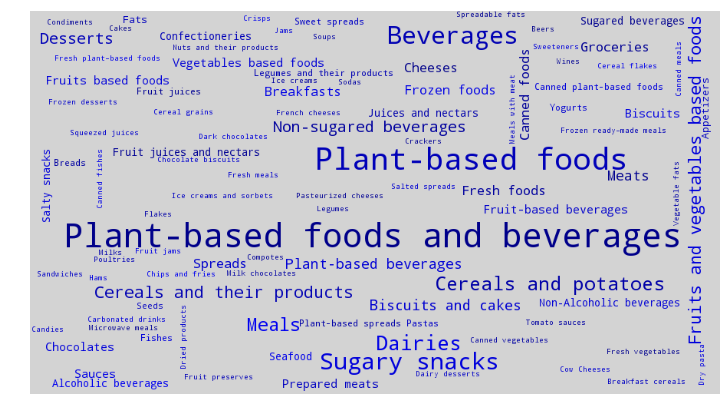

In [18]:
#_____________________________________________
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(11,9))
ax1 = fig.add_subplot(1,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_census[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 170.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=900,height=500, background_color='lightgray', 
                      max_words=1628,relative_scaling=0.6,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
plt.show()

#### 1.4.2 The **pnns_groups_1** and  **pnns_groups_2** variables

These columns give classifications which are more general than in the **categories_en** variable:

In [19]:
pnns_group1_keys = count_words(df_new, 'pnns_groups_1')  
pnns_group2_keys = count_words(df_new, 'pnns_groups_2')  

Nb of categories in 'pnns_groups_1': 14
Nb of categories in 'pnns_groups_2': 42


In what follows, I will only use the **pnns_groups_1** and then focus on it:

In [20]:
pnns_group1_keys

['sugary-snacks',
 'Fish Meat Eggs',
 'Fruits and vegetables',
 'fruits-and-vegetables',
 'Fat and sauces',
 'Cereals and potatoes',
 'Composite foods',
 'Sugary snacks',
 'Milk and dairy products',
 'cereals-and-potatoes',
 'salty-snacks',
 'Salty snacks',
 'Beverages',
 'unknown']

In [21]:
corresp = dict()
corresp['cereals-and-potatoes']  = 'Cereals and potatoes'
corresp['fruits-and-vegetables'] = 'Fruits and vegetables'
corresp['sugary-snacks'] = 'Sugary snacks'
corresp['salty-snacks'] = 'Salty snacks'

In [22]:
df_new['pnns_groups_1'] = df_new['pnns_groups_1'].replace(corresp)
pnns_group1_keys = count_words(df_new, 'pnns_groups_1')
pnns_group1_keys

Nb of categories in 'pnns_groups_1': 10


['Fish Meat Eggs',
 'Fruits and vegetables',
 'Fat and sauces',
 'Cereals and potatoes',
 'Composite foods',
 'Sugary snacks',
 'Milk and dairy products',
 'Salty snacks',
 'Beverages',
 'unknown']

___
## 1.5 Filling factor

In [23]:
col_filling = filling_factor(df_new)

In [24]:
# y_axis  = list(col_filling['filling_factor'])
# x_axis  = [i for i in range(len(col_filling))]
# x_label = list(col_filling['column_name'])
# fig = plt.figure(figsize=(10, 22))
# plt.yticks(x_axis, x_label)
# plt.title('Filling factor (%)', fontsize = 15)
# plt.barh(x_axis, y_axis)
#plt.show()

In [25]:
col_filling_2 = col_filling.loc[col_filling['filling_factor'] < 0.2]
# y_axis  = list(col_filling_2['filling_factor'])
# x_axis  = [i for i in range(len(col_filling_2))]
# x_label = list(col_filling_2['column_name'])
# fig = plt.figure(figsize=(11, 8))
# plt.xticks(rotation=90)
# plt.xticks(x_axis, x_label)
# plt.ylabel('Filling factor (%)', fontsize = 15)
# plt.bar(x_axis, y_axis)
# plt.axhline(y=0.02, linewidth=2, color = 'r')
# plt.text(5, 0.025, 'threshold for deletion', fontsize = 16, color = 'r')
# plt.tight_layout()
#plt.show()

From these graphs, we can see that many variables do not contain a significant number of products. I then decide to drop the columns that contain less than 70 products:

In [26]:
columns_to_remove = list(col_filling[df_new.shape[0] - 
                                     col_filling['missing_count'] < 70]['column_name'])
columns_to_remove

['-myristic-acid_100g',
 '-montanic-acid_100g',
 '-stearic-acid_100g',
 '-palmitic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-maltose_100g',
 'nucleotides_100g',
 '-arachidonic-acid_100g',
 '-maltodextrins_100g',
 '-oleic-acid_100g',
 '-gondoic-acid_100g',
 'serum-proteins_100g',
 'molybdenum_100g',
 'allergens_en',
 'chromium_100g',
 'omega-9-fat_100g',
 '-behenic-acid_100g',
 '-dihomo-gamma-linolenic-acid_100g',
 'cities',
 '-arachidic-acid_100g',
 '-gamma-linolenic-acid_100g',
 'casein_100g',
 '-glucose_100g',
 'taurine_100g',
 'beta-carotene_100g',
 '-eicosapentaenoic-acid_100g',
 '-fructose_100g',
 'ph_100g']

In [27]:
df_new.drop(columns_to_remove, axis = 1, inplace = True)

### 1.6 Dispersion of the products content

Now, I have a look at the dispersion of nutritional properties.

In [28]:
df_new.rename(columns={'biotin_100g':'vitamin-b7_100g'}, inplace=True)
df_new.rename(columns={'pantothenic-acid_100g':'vitamin-b5_100g'}, inplace=True)
df_new.rename(columns={'vitamin-pp_100g':'vitamin-b3_100g'}, inplace=True)

In [29]:
quantite = ['energy_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-b3_100g',
            'vitamin-b6_100g','vitamin-b9_100g','vitamin-b5_100g', 'vitamin-b7_100g',
            'vitamin-b12_100g', 'vitamin-e_100g', 'zinc_100g','copper_100g']

In [30]:
sigma = [0 for _ in range(12)]
mediane = [0 for _ in range(12)]
for i in range(len(quantite)):
    colonne = quantite[i]
    mediane[i] = df_new[pd.notnull(df_new[colonne])][colonne].median()
    test = df_new[pd.notnull(df_new[colonne])][colonne]
    test = test.sort_values()    
    if i != 4: sigma[i] = np.std(test[:-15])
    else :     sigma[i] = np.std(test[:-25])

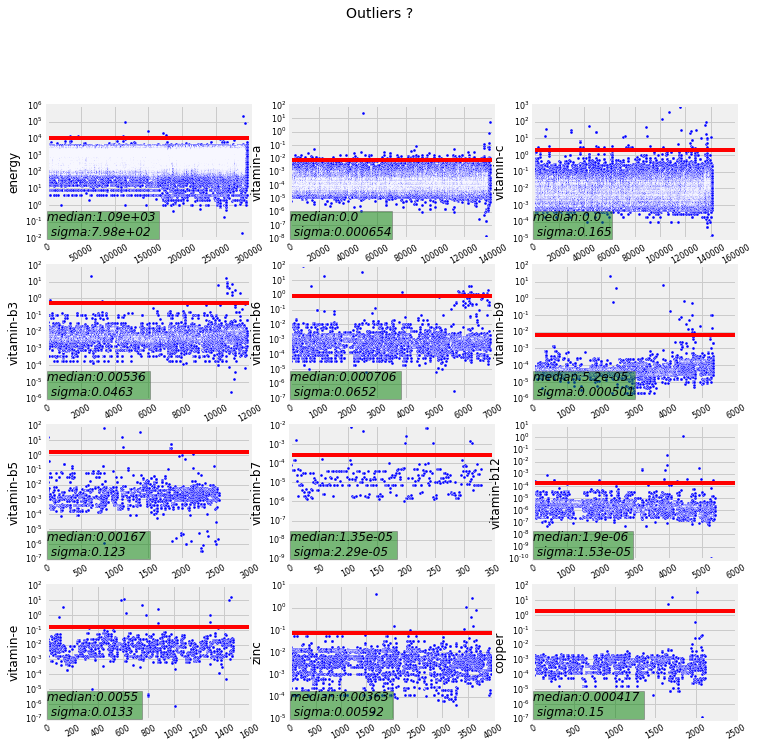

In [31]:
#plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize=(11,11))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    colonne = quantite[i]
    test = df_new[pd.notnull(df_new[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=mediane[i] + 12*sigma[i], color='r', linestyle='-')
    ax.text(0., 0.02, 'median:{:.3} \n sigma:{:.3}'.format(mediane[i], sigma[i]),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'green', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, "Outliers ?", ha='center', fontsize = 14)
# plt.tight_layout()

Lookgin at these figures, we can see that for the products I selected, some products differ from the median value by more than $12 \, \sigma$. I have a look at some of these products to see if this could correspond to bad entries in the database:

In [32]:
df_new[df_new['energy_100g'] > 100000][['product_name', 'energy_100g']]

,product_name,energy_100g
347260,"Nusco, Chocolate Spread, Chocolate",231199


well, in 100 grams of the product _"pois cassés"_ (split peas), it is indicated we have $\sim$3'000'000 kcal. Such an amount of energy would allow a man to survive during $\sim$4 years which looks a but excessive ... Hence, I supress a few entries according to the $12\,\sigma$ criteria :

In [33]:
for i in range(len(quantite)):
    colonne = quantite[i]
    print('{:<30}: deletion if > {}'.format(colonne, round(mediane[i] + 12*sigma[i],3)))
    mask1 = df_new[colonne] > (mediane[i] + 12*sigma[i])
    df_new = df_new.drop(df_new[mask1].index)

energy_100g                   : deletion if > 10663.717
vitamin-a_100g                : deletion if > 0.008
vitamin-c_100g                : deletion if > 1.98
vitamin-b3_100g               : deletion if > 0.561
vitamin-b6_100g               : deletion if > 0.783
vitamin-b9_100g               : deletion if > 0.006
vitamin-b5_100g               : deletion if > 1.476
vitamin-b7_100g               : deletion if > 0.0
vitamin-b12_100g              : deletion if > 0.0
vitamin-e_100g                : deletion if > 0.165
zinc_100g                     : deletion if > 0.075
copper_100g                   : deletion if > 1.803


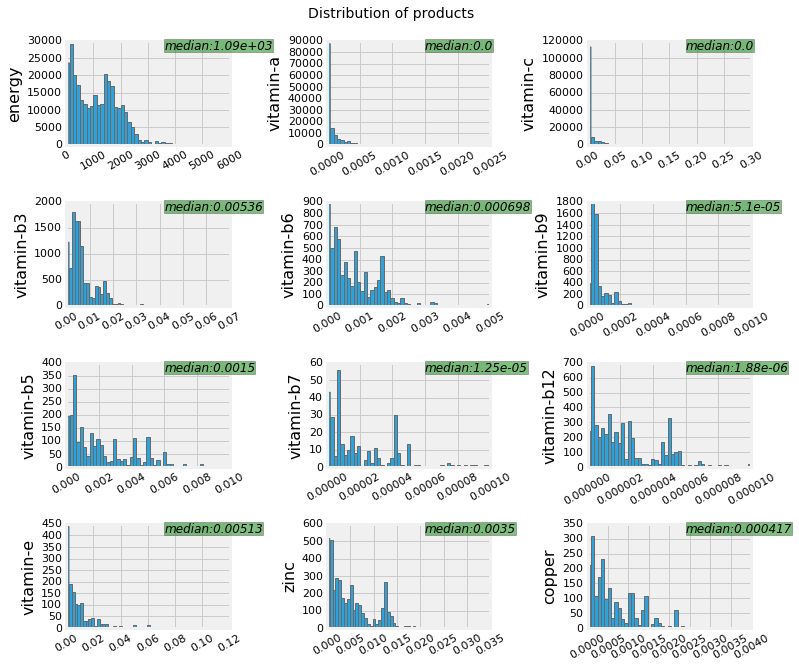

In [34]:
tPlot, axes = plt.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize=(11,9))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    colonne = quantite[i]
    mediane_2 = df_new[pd.notnull(df_new[colonne])][colonne].median()
    test = df_new[pd.notnull(df_new[colonne])][colonne]  
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 16)
    ax.tick_params(labelcolor='black', top='off', bottom='on', left='on',
                   right='off', labelsize = 11)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    
    if   i == 1: ax.hist(test, bins=np.linspace(0,0.0025,50))
    elif i == 0: ax.hist(test, bins=range(0,6000,125))
    elif i == 2: ax.hist(test, bins=np.linspace(0,0.3,50))
    elif i == 3: ax.hist(test, bins=np.linspace(0,0.06,50))
    elif i == 4: ax.hist(test, bins=np.linspace(0,0.005,50))
    elif i == 5: ax.hist(test, bins=np.linspace(0,0.001,50))
    elif i == 6: ax.hist(test, bins=np.linspace(0,0.01,50))
    elif i == 7: ax.hist(test, bins=np.linspace(0,0.0001,50))
    elif i == 8: ax.hist(test, bins=np.linspace(0,0.00001,50))
    elif i == 9: ax.hist(test, bins=np.linspace(0,0.1,50))
    elif i == 10: ax.hist(test, bins=np.linspace(0,0.03,50))
    elif i == 11: ax.hist(test, bins=np.linspace(0,0.004,50))
    
    ax.text(0.6, 0.92, 'median:{:.3}'.format(mediane_2), style='italic', fontsize = 12,
            transform=ax.transAxes, bbox={'facecolor':'green','alpha':0.5,'pad':0})
    i += 1
    
tPlot.text(0.5, 1.01, "Distribution of products", ha='center', fontsize = 14)
plt.tight_layout()

### 1.7 Further Cleaning

In [35]:
#Since we're only looking at nutrition, we're deleting these columns
df_new.drop(df_new[['code', 'url', 'creator', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'packaging', 'packaging_tags', 
                       'manufacturing_places', 'manufacturing_places_tags', 'first_packaging_code_geo', 'image_url', 
                        'image_small_url', 'stores','cities_tags','emb_codes','emb_codes_tags','cities_tags','origins',
                   'created_t','states_en']], axis=1, inplace=True)

In [36]:

#Limit to only US products
df_new = df_new[df_new['countries_en'] == 'United States']

In [37]:
#Now that we have just the US columns, we can get rid of the countries column
df_new.drop(df_new[['countries_en']])

ValueError: labels ['countries_en'] not contained in axis

In [211]:
def convert_serving_size(serving_sizes):
    '''Returns servings in grams'''
    serving_sizes_num = []
    for serving_size in serving_sizes:
        try:
            serving_g = int(serving_size.split()[0])
            serving_sizes_num.append(serving_g)
        except:
            serving_sizes_num.append(0)
    return np.array(serving_sizes_num)

def calories(fat,carbs,protein):
    return 9*fat + 4*carbs + 4*protein

def is_organic(name):
    print('organic' in str(name).lower())
    return 

In [320]:
test_dim = len(df_new)
df_test = pd.DataFrame(df_new[:test_dim])
serving_size = df_new['serving_size'][:test_dim]
product_test = df_new['product_name'][:test_dim]
nutrients =list(['energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g','omega-3-fat_100g', '-alpha-linolenic-acid_100g','-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g','trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
                     'sugars_100g', '-sucrose_100g', '-lactose_100g', 'starch_100g','polyols_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'vitamin-d_100g',
                     'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g','vitamin-b2_100g', 'vitamin-b3_100g', 'vitamin-b6_100g','vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g','vitamin-b7_100g', 'vitamin-b5_100g', 'silica_100g', 'bicarbonate_100g','potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g','iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g','manganese_100g', 'fluoride_100g', 'selenium_100g', 'iodine_100g','caffeine_100g', 'fruits-vegetables-nuts_100g','fruits-vegetables-nuts-estimate_100g','collagen-meat-protein-ratio_100g', 'cocoa_100g','carbon-footprint_100g', 'nutrition-score-fr_100g'])
serving_sizes = convert_serving_size(serving_size)
for nutrient in nutrients:
    nutrient_serving = df_test[nutrient]*serving_sizes//100
    df_test[nutrient] = nutrient_serving
    new_nutrient = nutrient.replace('100g','per serving (g)')
    new_nutrient = new_nutrient.replace('_', ' ', 5)
    df_test.rename(columns={nutrient:new_nutrient}, inplace=True)
df_test.fillna(0, inplace=True)
df_test['Calories per serving'] = calories(df_test['fat per serving (g)'],df_test['carbohydrates per serving (g)'],df_test['proteins per serving (g)'])
df_test.index = product_test.astype(str)
#df_test 'organic' in [df_test['product_name']]
#df_test['is organic'] = is_org_col
#df_test[['Peanuts']]
#df_test[['Calories per serving', 'labels_en','proteins per serving (g)','carbohydrates per serving (g)']]
#df_test['product_name',dtype=str]


In [349]:
#working wth df_basic
import json

df_basic= pd.DataFrame(df_test[['product_name', 'Calories per serving', 'fat per serving (g)','proteins per serving (g)','carbohydrates per serving (g)']])

initial = ['Calories per serving', 'fat per serving (g)','proteins per serving (g)','carbohydrates per serving (g)']
final = ['calories', 'fat', 'pro', 'carbs']

for i in range(len(final)):
    df_basic.rename(columns={initial[i]:final[i]}, inplace=True)
#df_basic= pd.DataFrame(df_test[['Calories per serving', 'fat per serving (g)','proteins per serving (g)','carbohydrates per serving (g)']])
#df_basic.dropna(subset='product_name')
df_basic.index = product_test
df_basic.dropna(subset=['product_name'])
df_basic.drop(df_basic[['product_name']])
#organic_tags = []
dict_test = df_basic.to_dict('index')

#df_test['product_name']
#dict_test.keys().lower
#print(dict_test.keys())
#print(dict_test.keys())
# for k in dict_test.keys():
# #     #organic_tags.append('organic' in k.lower())
#     try:
#         labels.append(k.lower())
#     except:
#         pass
# #     #.replace('organic', '')
    
# #print(len(organic_tags),len(df_basic))
# #['organic'] = organic_tags
# df_basic.index = labels
# for label in labels:
#     dict_test.add("organic" in label)
        

#df_basic.rename(columns={df_basic.index:df_basic.index.lower()}, inplace=True)
with open("basic.json", "w") as outfile:
    try:
        json.dump(dict_test,outfile)
    except:
        pass
    
#print(dict_test)
#print(dict_test)
#print(dict_test)
    #json.dumps(outfile, ensure_ascii=False)
#product_test = df_new['product_name'][:test_dim]
#df_test.index = product_test
#df_test[['Peanuts']]
#df_test['is_organic'] = 'organic' in df_test[product_test]
#df_test['is_organic'] = is_organic(df_test[product_test])
#df_test['is organic'] = is_organic(product_test)
#df_test[['product_name','Calories per serving', 'is organic','proteins per serving (g)','carbohydrates per serving (g)']]
#df_test.columns
# df_test.drop(df_test[['states_en']])
# df_test.columns

In [364]:
#df_basic.index[640:740]
df_basic[df_basic['pro'] > 50]

,product_name,calories,fat,pro,carbs
product_name,,,,,
Grilled Lemon Herb Chicken Breast Cutlet,Grilled Lemon Herb Chicken Breast Cutlet,356,8,66,5
Grilled Chicken Breast Cutlet,Grilled Chicken Breast Cutlet,307,7,61,-0
Boil Crawfish Complete Kit,Boil Crawfish Complete Kit,635,23,55,52
Four Cheese Stuffed Chicken Kiev,Four Cheese Stuffed Chicken Kiev,413,17,51,14
"Chicken, Honey Mustard","Chicken, Honey Mustard",895,43,52,75
Classic Italian Sandwich,Classic Italian Sandwich,1137,65,57,81
Large American Hoagie,Large American Hoagie,727,23,54,76
Large Roast Beef Hoagie,Large Roast Beef Hoagie,735,23,60,72
Turkey With White American Cheese Lettuce & Tomato,Turkey With White American Cheese Lettuce & To...,691,23,54,67


In [229]:
df_test.to_json("food_db.json")

In [ ]:
#Write to file
df_new.to_csv("nutrition.csv",encoding='utf-8')


In [38]:
# df_new[['ingredients_text']]=df_new[['ingredients_text']].astype(list)
# df_new.dtypes
df_new.to_json("nutrition.json")

In [ ]:
ingredients = df_new['ingredients_text']
products = df_new['product_name']

In [ ]:
# df_ingredients = pd.DataFrame(data=df_new['ingredients_text'],index=df_new['product_name'])
# df_ingredients

In [ ]:
ing1 = pd.DataFrame(ingredients)
ing1.index = products
ing1.head()

In [ ]:
ing1.to_csv("ingredients.csv",encoding='utf-8')

In [ ]:
df_new.index = products
df_new.head(15)

In [71]:
df_new.product_name[df_new['proteins_100g']>10]

2                                                Peanuts
3                                 Organic Salted Nut Mix
5                      Breadshop Honey Gone Nuts Granola
7                                         Organic Muesli
10                                  Organic Adzuki Beans
11                                   Organic Penne Pasta
12                                         Zen Party Mix
13                             Organic Golden Flax Seeds
14                                   Organic Spicy Punks
15                                  Cinnamon Nut Granola
16                                     Organic Hazelnuts
19                                    Organic Oat Groats
21                 Antioxidant Mix - Berries & Chocolate
22             Organic Quinoa Coconut Granola With Mango
26                   Organic Unswt Berry Coconut Granola
27                   Roasted Salted Black Pepper Cashews
28                            Thai Curry Roasted Cashews
29                             

## 2. Correlations

In [ ]:
sns.set(context="paper", font_scale = 1.2)
corrmat = df_new.corr()
f, ax = plt.subplots(figsize=(12, 12))
f.text(0.45, 0.93, "Pearson's correlation coefficients", ha='center', fontsize = 18)
sns.heatmap(corrmat, square=True, linewidths=0.01, cmap="coolwarm")
plt.tight_layout()

In [ ]:
sns.set(context="paper", font_scale = 1.2)
f, ax = plt.subplots(figsize=(11, 11))
cols = corrmat.nlargest(25, 'carbohydrates_100g')['carbohydrates_100g'].index
cm = corrmat.loc[cols, cols] 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation with carbohydrates", ha='center', fontsize = 18)
plt.show()

In [ ]:
sns.set(context="paper", font_scale = 1.2)
f, ax = plt.subplots(figsize=(11, 11))
cols = corrmat.nlargest(25, 'nutrition-score-uk_100g')['nutrition-score-uk_100g'].index
cm = corrmat.loc[cols, cols] 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Correlation with nutrition score", ha='center', fontsize = 18)
plt.show()

____
## 3. Evaluating the quality of products 
____
### 3.1 Nutrition grade

In [ ]:
df_new['pnns_groups_1'].unique()

In [ ]:
categ_prod = [] ; label_prod = []
for i,s in enumerate(df_new['pnns_groups_1'].unique()):
    if isinstance(s, float): continue
    if s == 'unknown': continue    
    produit = str(s)
    df1 = df_new[df_new['pnns_groups_1'] == produit]
    table_1 = pd.Series(df1[pd.notnull(df1['nutrition-score-uk_100g'])]['nutrition-score-uk_100g'])
    categ_prod.append(table_1)
    label_prod.append(s)

In [ ]:
tPlot, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=False, figsize=(11,7))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    t = categ_prod[i].value_counts(sort=True)
    t.sort_index(inplace=True)
    hist = list(t)
    bins = list(t.index)
    
    ax.tick_params(labelcolor='black', top='off', bottom='on', left='on', right='off')
    ax.set_ylabel(label_prod[i], fontsize = 12)
    ax.hist(categ_prod[i], bins=range(-20,36,2), edgecolor = 'k')

    mediane = int(categ_prod[i].median())
    color = 'green' if mediane <= 4 else 'red'
    if mediane < 11:
        ax.text(0.68, 0.9, 'mediane:{}'.format(int(categ_prod[i].median())), style='italic',
                transform=ax.transAxes, fontsize = 12,
                bbox={'facecolor':color, 'alpha':0.8, 'pad':5})
    else:
        ax.text(0.02, 0.9, 'mediane:{}'.format(int(categ_prod[i].median())), style='italic',
                transform=ax.transAxes, fontsize = 12,
                bbox={'facecolor':'red', 'alpha':0.8, 'pad':5})
    i += 1

tPlot.text(0.5, 1.01, 'nutrition sore', ha='center', fontsize = 18)
plt.tight_layout()


### 3.2 Nutriments

In [ ]:
liste_columns = ['fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g',
                 'proteins_100g', 'salt_100g']

In [ ]:
df_new[liste_columns][:5]

In [ ]:
df_chart = df_new[pd.notnull(df_new[liste_columns]).all(axis = 1)]
mean_values = list(df_chart[liste_columns].mean().values)

I adapated a script found on [stackoverflow](https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot) to draw a radar chart.

In [ ]:
def spider(values, cat, ax):
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]
    # for circularity
    values += values[:1]
    x_as += x_as[:1]
    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Set position of y-labels
    ax.set_rlabel_position(0)
    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    # Set ticks values and labels    
    ax.set_xticks(x_as[:-1])
    ax.set_xticklabels([])
    ax.set_yticks([0.1, 0.5, 1, 2, 10])
    ax.set_yticklabels(["0.1", "0.5", "1", "2", "10"])
    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)
    # Fill area
    ax.fill(x_as, values, 'b', alpha=0.3)
    # Set axes limits
    ax.set_ylim(0, 3)
    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 3
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        elif angle_rad == pi:
            ha, distance_ax = "center", 3
        else:
            ha, distance_ax = "right", 3

        ax.text(angle_rad, 0.2+distance_ax, cat[i], size=10,
                horizontalalignment=ha, verticalalignment="center")

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, subplot_kw=dict(projection='polar'), figsize=(11,11))
axes = np.array(axes)

list_nutriments = [s.strip('_100g') for s in liste_columns]

ind = 0
for ax in axes.reshape(-1):
    ind += 1
    ind2 = 4*ind
    absolute_values = list(df_chart.iloc[ind2][liste_columns].T.values)
    values  = [ val/mean_values[i] for i, val in enumerate(absolute_values)]
    spider(values, list_nutriments, ax)
    ax.set_title(df_chart.iloc[ind2]['product_name'], fontsize = 15)
    
fig.subplots_adjust(hspace=0.5)
plt.show()

# Deleting Columns That We Won't Use

In [ ]:
df_new.drop(df_new[['code', 'url', 'creator', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'packaging', 'packaging_tags', 
                       'manufacturing_places', 'manufacturing_places_tags', 'first_packaging_code_geo', 'image_url', 
                        'image_small_url', 'stores','countries_en','cities_tags','emb_codes','emb_codes_tags','cities_tags','origins',
                   'created_t']], axis=1, inplace=True)

In [ ]:
df_new.columns

In [ ]:
df_new.to_csv("nutrition.csv")


In [ ]:
df_new['countries_en'] = df['countries_en']

In [ ]:
df_new.columns

In [ ]:
df_new = df_new[df_new['countries_en'] == 'United States']

In [ ]:
df_new.info()

In [ ]:
df_new.columns[:]

In [ ]:
df_new.to_csv("nutrition.csv",encoding=['utf-8'])

In [ ]:
df_products = pd.DataFrame(df_new['product_name'],df_new['ingredients_text'])

df_products.to_csv("ingredients.csv")